In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from itertools import combinations_with_replacement
from scipy.spatial.distance import cosine

from copy import copy
import os
import gc

from qa_system import QuestionAnswerSystem
from utils import Utility

In [2]:
df = pd.read_csv('train_task_b.csv')
df = df.set_index('question_id')

## Создаем БД

In [3]:
qa_system = QuestionAnswerSystem()
qa_system.create_database(df, database_origin_dir='database_origin', database_lem_dir='database_lem')
qa_system.add_database_to_index(database_dir='database_lem', index_dir='index')

100%|██████████| 9078/9078 [00:07<00:00, 1265.48it/s]


## Переводим вопрос и ответ в лемматизированную форму

In [3]:
tqdm_pandas(tqdm(total=df.index.nunique()))
df['question_lem'] = df.groupby('question_id').progress_apply(lambda x: Utility.lemmatize_question(x.question.values[0]))
df['answer_lem'] = df.groupby('question_id').progress_apply(lambda x: Utility.lemmatize(x.answer.values[0]))

  0%|          | 0/50364 [00:00<?, ?it/s]
50365it [01:37, 515.52it/s]                            
100%|██████████| 50365/50365 [00:55<00:00, 906.09it/s] 


## Выбираем лучший алгоритм поиска релевантного документа на подвыборке

In [4]:
df_sample = df.sample(frac=0.01, random_state=0)

In [7]:
## Freq: 0.66
## Tf-idf: 0.88
## Bm25f: 0.9688
## MAX_INTERSECT_DOC: 0.76


## BM25F. limit = 50. Accuracy: 0.999. MEAN_NUM_SENTENCE: 265.
## Bm25f. limit = 10. Accuracy: 0.994. MEAN_NUM_SENTENCE: 55.
## Bm25f. limit = 5. Accuracy: 0.989. MEAN_NUM_SENTENCE: 28.
## Bm25f. limit = 1. Accuracy: 0.949. MEAN_NUM_SENTENCE: 6.

search_rel_question_doc_alg_str = "BM25F_small_set"
if not os.path.exists(search_rel_question_doc_alg_str):
    os.mkdir(search_rel_question_doc_alg_str)
qa_system = QuestionAnswerSystem(search_rel_question_doc_alg_str) 

qa_system = QuestionAnswerSystem(search_rel_question_doc_alg_str)

accuracy = 0
errors = {}
for question_lem, paragraph_id, question_id in tqdm(df_sample.reset_index()[['question_lem', 'paragraph_id', 'question_id']].values, total=df_sample.question.nunique()):
    doc_ids = qa_system.find_rel_question_doc_ids(question_str_lem=question_lem, index_dir='index')
    if paragraph_id in doc_ids:
        accuracy += 1
    else:
        errors[question_id] = copy(doc_ids)
    np.save('{}/{}.npy'.format(search_rel_question_doc_alg_str, question_id), doc_ids)
np.save('{}_interrogative_pronouns_errors.npy'.format(search_rel_question_doc_alg_str), errors)
print('{}: Accuracy: {}'.format(search_rel_question_doc_alg_str, accuracy/df_sample.question.nunique()))

100%|██████████| 504/504 [00:25<00:00, 19.72it/s]

BM25F_small_set: Accuracy: 0.9821428571428571


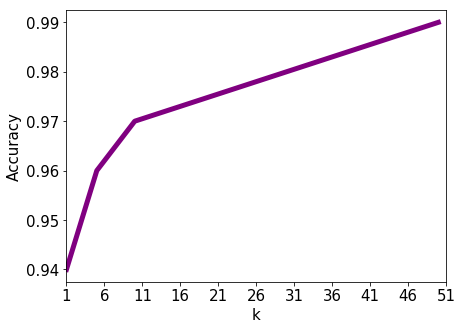

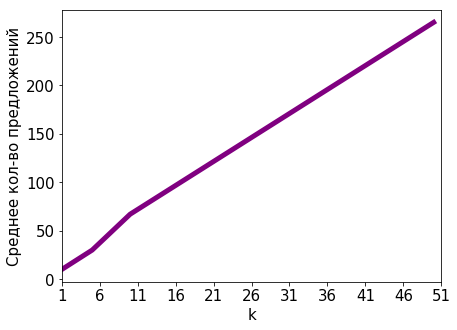

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.8, 5))
limits = [50,10, 5, 1]
accuracies = [0.99, 0.97, 0.96, 0.94]
mean_n_sentences = [265, 67, 30, 10]

plt.plot(limits, accuracies, lw=5, color='purple')
plt.xlabel('k', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlim([1, 50])
plt.xticks(list(range(1, 51, 5)) + [51])
plt.tick_params(labelsize=15)
plt.savefig('acc_k.png')
plt.show()

plt.figure(figsize=(6.8, 5))
plt.plot(limits, mean_n_sentences, lw=5, color='purple')
plt.xlabel('k', fontsize=15)
plt.xlim([1, 50])
plt.xticks(list(range(1, 51, 5)) + [51])
plt.ylabel('Среднее кол-во предложений', fontsize=15)
plt.tick_params(labelsize=15)
plt.savefig('n_sent_k.png')
plt.show()

## Для лучшего алгоритма делаем пересчет по всей коллекции

In [4]:
search_rel_question_doc_alg_str = "BM25F"
if not os.path.exists(search_rel_question_doc_alg_str):
    os.mkdir(search_rel_question_doc_alg_str)
qa_system = QuestionAnswerSystem(search_rel_question_doc_alg_str) 

accuracy = 0
errors = {}
for question_lem, paragraph_id, question_id in tqdm(df.reset_index()[['question_lem', 'paragraph_id', 'question_id']].values, total=df.question.nunique()):
    doc_ids = qa_system.find_rel_question_doc_ids(question_str_lem=question_lem)
    if paragraph_id in doc_ids:
        accuracy += 1
    else:
        errors[question_id] = doc_ids
    np.save('{}/{}.npy'.format(search_rel_question_doc_alg_str, question_id), doc_ids)
np.save('{}_interrogative_pronouns_errors.npy'.format(search_rel_question_doc_alg_str), errors)
print('{}: Accuracy: {}'.format(search_rel_question_doc_alg_str, accuracy/df.question.nunique()))

50364it [1:33:29,  8.98it/s]                           

BM25F: Accuracy: 0.9726971267449018


## Формируем датасет для обучения (этап 2)
## Не учитываем те вопросы, по которым ошиблись на этапе 1

In [2]:
search_rel_question_doc_alg_str = 'BM25F'
errors = np.load('{}_interrogative_pronouns_errors.npy'.format(search_rel_question_doc_alg_str)).item()
train_df = QuestionAnswerSystem.create_train_dataset(errors=errors)

tqdm_pandas(tqdm(total=train_df.shape[0]))
train_df['sentence_lem'] = train_df.progress_apply(lambda x: Utility.lemmatize(x.sentence), axis=1)
train_df.to_pickle('train_df.pkl')

100%|██████████| 2718499/2718499 [2:30:25<00:00, 301.20it/s]  


## Делаем разметку для классификатора

In [24]:
train_df = pd.merge(train_df, df.reset_index()[['question_id', 'question', 'question_lem', 'answer', 'answer_lem']], how='left', on='question_id')
train_df_with_target = QuestionAnswerSystem.create_target(train_df)
train_df_with_target.to_pickle('train_df_with_target.pkl')

100%|██████████| 2718499/2718499 [04:32<00:00, 9986.65it/s] 


## Фильтруем датасет по наличию хотя бы одного предложения с ответом

In [27]:
train_df_with_target = train_df_with_target.set_index('question_id')
train_df_with_target = train_df_with_target[train_df_with_target.groupby('question_id').apply(lambda x: any(x.answer_in_sentence == 1))]
train_df_with_target.to_pickle('train_df_with_target_filtered.pkl')

/Users/daria_soboleva/anaconda3/envs/icutestenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Этап 2. Построение классификатора Ans_in_sentence

### 4% вопросов отсеялись на этапе 1

In [2]:
df = pd.read_pickle('train_df_with_target_filtered.pkl').reset_index()
df.drop_duplicates(subset=['question_id', 'sentence'], keep='first', inplace=True)
df = df.set_index('question_id')

In [3]:
train_df_idxs, test_df_idxs = Utility.train_test_split(df)

### Базовые статистики

In [ ]:
import pickle
with open('idfs.pickle', 'rb' ) as f:
    idfs = pickle.load(f)
with open('idfs_lema.pickle', 'rb' ) as f:
    idfs_lem = pickle.load(f)
    
tqdm_pandas(tqdm(total=df.index.nunique()))
base_stats = df.groupby('question_id').progress_apply(lambda x: 
                                                     QuestionAnswerSystem.get_base_stats(
                                                         x.question.values[0],
                                                         list(x.sentence),
                                                         x.question_lem.values[0],
                                                         list(x.sentence_lem)
                                                     )).reset_index()
base_stats.drop('level_1', axis=1, inplace=True)
base_stats.columns = [
    'question_id',
    'unique_word_count_score',
    'unique_lem_word_count_score',
    
    'unique_word_percent_score',
    'unique_lem_word_percent_score',
    
    'sentence_len',
    'sentence_lem_len',
    
    'bm25f_score',
    'bm25f_lem_score',
    
    'tf_idf_score',
    'tf_idf_lem_score',
    
    'sentence',
    'sentence_lem'
]
base_stats.drop('sentence_lem', inplace=True, axis=1)
base_stats.to_pickle('base_stats.pkl')
df = pd.merge(df.reset_index(), base_stats, how='left', on=('question_id', 'sentence')).set_index('question_id')

In [5]:
base_stats = pd.read_pickle('base_stats.pkl')
base_stats.drop_duplicates(subset=['question_id', 'sentence'], keep='first', inplace=True)
df = pd.merge(df.reset_index(), base_stats, how='left', on=('question_id', 'sentence')).set_index('question_id')

### Бейзлайны:
* max_unique_word_count_score
* max_unique_word_percent_score
* max_tf_idf_score
* max_bm25f_score

In [5]:
def get_scores(df, columns):
    n_questions = df.index.nunique()
    scores = {}
    tqdm_pandas(tqdm(total=n_questions))
    for col in columns:
        scores[col] = df.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, col)).sum()/n_questions
    return scores

train_scores = get_scores(df.loc[train_df_idxs], base_stats.columns.difference(['question_id', 'sentence_len', 'sentence_lem_len', 'sentence']))
test_scores = get_scores(df.loc[test_df_idxs], base_stats.columns.difference(['question_id', 'sentence_len', 'sentence_lem_len', 'sentence']))

scores = {'Train': {}, 'Test': {}}
scores['Train'] = train_scores
scores['Test'] = test_scores
pd.DataFrame(scores).T

  0%|          | 0/33767 [00:00<?, ?it/s]
33768it [00:21, 1600.23it/s]                           
  0%|          | 0/14471 [00:00<?, ?it/s]
14472it [00:08, 1787.35it/s]                           
100%|██████████| 14472/14472 [00:08<00:00, 1671.17it/s]


,bm25f_lem_score,bm25f_score,tf_idf_lem_score,tf_idf_score,unique_lem_word_count_score,unique_lem_word_percent_score,unique_word_count_score,unique_word_percent_score
Test,0.937166,0.920760,0.932218,0.921084,0.940105,0.940105,0.928041,0.928041
Train,0.938901,0.922034,0.933665,0.922082,0.941904,0.941904,0.929850,0.929850


### Лог-регрессия на базовых фичах

In [6]:
target = 'answer_in_sentence'
predictors = df.columns.difference([
    'sentence',
    'sentence_lem',
    'question',
    'question_lem',
    'answer',
    'answer_lem',
    target
])
df_train = df.loc[train_df_idxs].copy()
df_test = df.loc[test_df_idxs].copy()

sc = StandardScaler()
X_train_sc = sc.fit_transform(df_train[predictors])
X_test_sc = sc.transform(df_test[predictors])

clf = LogisticRegression()
clf.fit(X_train_sc, df_train[target])

df_train['train_predict_proba'] = clf.predict_proba(X_train_sc)[:, 1]
df_test['test_predict_proba'] = clf.predict_proba(X_test_sc)[:, 1]

tqdm_pandas(tqdm(total=df_train.index.nunique()))
train_score = df_train.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'train_predict_proba')).sum()/df_train.index.nunique()

tqdm_pandas(tqdm(total=df_test.index.nunique()))
test_score = df_test.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'test_predict_proba')).sum()/df_test.index.nunique()

scores = {'Train': train_score, 'Test': test_score}
scores


  0%|          | 0/33767 [00:00<?, ?it/s]

 89%|████████▉ | 29996/33767 [00:32<00:04, 916.67it/s]


100%|█████████▉| 33674/33767 [00:36<00:00, 1021.63it/s]
33768it [00:36, 920.31it/s]                            
  0%|          | 0/14471 [00:00<?, ?it/s]

100%|█████████▉| 14440/14471 [00:16<00:00, 918.06it/s]
14472it [00:16, 898.62it/s]                           

{'Test': 0.9686258282162566, 'Train': 0.9698701282366897}

In [7]:
df_train_part = df_train.loc[df_train.index.unique()[:100]]
tmp = pd.read_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/train.csv')
df_train_part = pd.merge(df_train_part.reset_index(), tmp[['question_id', 'question_type_ner']], how='left', on='question_id')
df_train_part.to_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/pups.csv')

In [15]:
for question_id in df_train_part.question_id.unique():
    arranged = df_train_part[df_train_part.question_id == question_id].sort_values(by='train_predict_proba', ascending=False)
    for _, row in arranged.iterrows():

Чем осуществляется в международной торговле расчёт наличными? 0.9592789873176076


In [30]:
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

[(3, 4), (4, 3), (1, 2), (2, 1), (0, 0)]

In [38]:
question = 'Как называется одно из механических изменений в почвенном профиле, которое состоит в перемешивании почвенной массы под влиянием разницы температур'

In [40]:
tmp = df_train_part[df_train_part.question == question].sort_values(by='train_predict_proba', ascending=False)

In [43]:
tmp

,question_id,sentence,doc_number,sentence_lem,question,question_lem,answer,answer_lem,answer_in_sentence,unique_word_count_score,...,unique_word_percent_score,unique_lem_word_percent_score,sentence_len,sentence_lem_len,tf_idf_score,tf_idf_lem_score,bm25f_score,bm25f_lem_score,train_predict_proba,question_type_ner
54,1,Наличием мёрзлого слоя вызван целый ряд механи...,0,наличие мерзлый слой вызывать целый ряд механи...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,1,12,...,0.666667,0.733333,34,34,91.949027,83.537472,62.605182,52.566271,0.864427,NaN
51,1,"В почвах, расположенных в зоне длительной сезо...",0,"в почва , располагать в зона длительный сезонн...",Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,3,...,0.166667,0.200000,19,19,12.920806,9.211247,12.874493,9.228350,0.028996,NaN
65,1,Продолжительность ветра также сильно варьирует...,2,продолжительность ветер также сильно варьирова...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,3,...,0.166667,0.333333,54,54,10.418977,31.813401,5.832095,15.296752,0.025980,NaN
60,1,В зависимости от природы денатурирующего агент...,1,в зависимость от природа денатурировать агент ...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,1,...,0.055556,0.200000,27,27,-0.165671,14.823131,-0.139372,12.503562,0.016085,NaN
53,1,Образование слоев льда (шлиров) в почве привод...,0,образование слой лед ( шлир ) в почва приводит...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,2,...,0.111111,0.133333,21,21,2.146772,2.147050,2.033203,2.038252,0.013146,NaN
67,1,При остывании изделия или заготовки из стекла ...,3,при остывание изделие или заготовка из стекло ...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,3,...,0.166667,0.266667,22,22,10.328187,13.976638,9.580901,12.996677,0.010426,NaN
58,1,"Как правило, белки достаточно стабильны в тех ...",1,"как правило , белок достаточно стабильный в то...",Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,2,...,0.111111,0.133333,20,20,1.740548,3.994035,2.048423,4.239709,0.009143,NaN
57,1,Денатурацией белка называют любые изменения в ...,1,денатурация белка называть любой изменение в о...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,1,...,0.055556,0.133333,24,24,-0.165671,4.455165,-0.147621,3.979797,0.008287,NaN
55,1,Эти явления особенно широко распространены в т...,0,этот явление особенно широко распространять в ...,Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,1,...,0.055556,0.066667,8,8,-0.165671,-0.166243,-0.215709,-0.216720,0.007169,NaN
52,1,"Над мёрзлым слоем, который является водоупором...",0,"над мерзлый слой , который являться водоупор ,...",Как называется одно из механических изменений ...,называться один из механический изменение в по...,криотурбация,криотурбация,0,0,...,0.000000,0.000000,27,27,0.000000,0.000000,0.000000,0.000000,0.006845,NaN


In [18]:
pd.read_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/pups.csv', index_col=0)

,question_id,sentence,doc_number,sentence_lem,question,question_lem,answer,answer_lem,answer_in_sentence,unique_word_count_score,...,unique_word_percent_score,unique_lem_word_percent_score,sentence_len,sentence_lem_len,tf_idf_score,tf_idf_lem_score,bm25f_score,bm25f_lem_score,train_predict_proba,question_type_ner
0,0,Наличный платёж — операции с денежной наличнос...,0,наличный платеж — операция с денежный наличнос...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,0,...,0.000000,0.000000,13,13,0.000000,0.000000,0.000000,0.000000,0.005753,NaN
1,0,"Как правило, эти расчёты меньше по объёму по с...",0,"как правило , этот расчет мало по объем по сра...",Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,0,...,0.000000,0.166667,12,12,0.000000,11.225490,0.000000,8.570890,0.014415,NaN
2,0,Размер наличного расчёта обычно устанавливаетс...,0,размер наличный расчет обычно устанавливаться ...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,1,...,0.142857,0.333333,8,8,-0.165671,5.446502,-0.215709,7.100232,0.034437,NaN
3,0,К наличному расчёту относятся также выплаты пр...,0,к наличный расчет относиться также выплата пре...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,1,...,0.142857,0.333333,31,31,-0.165671,5.446502,-0.129708,4.276455,0.037556,NaN
4,0,Государство в лице центрального банка и минист...,0,государство в лицо центральный банка и министе...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,1,...,0.142857,0.333333,17,17,-0.165671,5.446502,-0.171273,5.642354,0.034788,NaN
5,0,В международной торговле расчёт наличными осущ...,0,в международный торговля расчет наличные осуще...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",1,6,...,0.857143,1.000000,10,10,35.576483,29.835088,43.796525,36.782010,0.959279,NaN
6,0,"Существование абсолютных преимуществ, когда да...",1,"существование абсолютный преимущество , когда ...",Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,2,...,0.285714,0.333333,31,31,4.160512,4.691521,3.257370,3.683663,0.036811,NaN
7,0,Именно на производстве таких товаров и следует...,1,именно на производство такой товар и следовать...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,3,...,0.428571,0.666667,25,25,12.542401,16.042146,11.041932,14.136918,0.229891,NaN
8,0,В результате такого обмена товарами между госу...,1,в результат такой обмен товар между государств...,Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,1,...,0.142857,0.166667,43,43,-0.828357,-0.831215,-0.246452,-0.247676,0.013239,NaN
9,0,"Иными словами, международная торговля превраща...",1,"иной слово , международный торговля превращать...",Чем осуществляется в международной торговле ра...,осуществляться в международный торговля расчет...,"чеками, переводами, аккредитивами, инкассо","чек , перевод , аккредитив , инкассо",0,1,...,0.142857,0.500000,1

### LGB

In [6]:
# Метрика (accuracy по вопросам)
clf = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, min_child_samples=1000, n_jobs=-1)
clf.fit(df_train[predictors], df_train[target])

df_train['train_predict_proba'] = clf.predict_proba(df_train[predictors])[:, 1]
df_test['test_predict_proba'] = clf.predict_proba(df_test[predictors])[:, 1]

tqdm_pandas(tqdm(total=df_train.index.nunique()))
train_score = df_train.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'train_predict_proba')).sum()/df_train.index.nunique()

tqdm_pandas(tqdm(total=df_test.index.nunique()))
test_score = df_test.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'test_predict_proba')).sum()/df_test.index.nunique()

scores = {'Train': train_score, 'Test': test_score}
scores

  0%|          | 0/33767 [00:00<?, ?it/s]
33768it [00:51, 654.10it/s]                           
  0%|          | 0/14471 [00:00<?, ?it/s]
14472it [00:24, 585.89it/s]                           


{'Test': 0.8253748877064474, 'Train': 0.82802736399443244}

### Интеракшенсы

In [6]:
# Тип вопроса
print('Тип вопроса start...{}'.format(df.shape))
df = Utility.applyParallel(df.groupby('question_id'), func=Utility.get_question_type)

# Неры предложений
print('Неры предложений start...{}'.format(df.shape))
res = Utility.applyParallel(df.reset_index().groupby('question_id'), func=Utility.get_sentence_ners)
res.columns = ['question_id', 'sentence', 'sentence_ners']
#res = pd.read_pickle('df_with_target_stat.pkl')[['question_id', 'sentence', 'sentence_ners']]
df = pd.merge(df.reset_index(), res, how='left', on=('question_id', 'sentence')).set_index('question_id')

# Индикаторы неров в предложениях
ners = ['Per', 'Geox', 'Orgn', 'Date', 'Num']
print('Индикаторы неров в предложениях start...{}'.format(df.shape))
for ner in ners:
    df[ner] = 0    
tqdm_pandas(tqdm(total=df.shape[0]))
df = df.progress_apply(lambda x: Utility.get_sentence_ners_indicators(x), axis=1)

# Статистику по таргету считаем только по трейну
print('Статистики start...{}'.format(df.shape))
df_right = df.loc[train_df_idxs]
df_right = df_right[df_right.answer_in_sentence == 1]

# Частоты всречаемости типов вопросов (фильтруем)
freqs = df_right.question_type.value_counts().reset_index()
freqs.columns = ['question_type', 'freq']
df_right = pd.merge(df_right, freqs, how='left', on='question_type')
df_right = df_right[df_right.freq > 1]

# global: сколько раз нер встретился в ответах на все типы вопросов
for ner in ners:
    df_right['{}_global'.format(ner)] = df_right[ner].sum() 
    
# local: сколько раз нер встретился в ответ на данный типа вопрос
tqdm_pandas(tqdm(total=df_right.question_type.nunique()))
df_right = df_right.groupby('question_type').progress_apply(lambda x: Utility.get_ners_counts_by_question_type(x, ners))
   
# Нормируем
for ner in ners:
    df_right['{}_local'.format(ner)] /= df_right['{}_global'.format(ner)].sum()
    
# Определяем самый типовой нер для данного типа вопроса
print('Типовой нер start...{}'.format(df.shape))
tqdm_pandas(tqdm(total=df_right.question_type.nunique()))
df_right = df_right.groupby('question_type').progress_apply(lambda x: Utility.get_most_freq_ner_question_type(x, ners))

# Вставляем в исходный датасет фичу
df = pd.merge(df.reset_index(), df_right[['question_type', 'question_type_ner', 'freq']].drop_duplicates(), how='left', on='question_type').set_index('question_id')

# Индикатор пересечения неров из предложения и вопроса
print('Пересечение start...{}'.format(df.shape))
tqdm_pandas(tqdm(total=df.index.nunique()))
res = df.reset_index().groupby('question_id').progress_apply(lambda x: Utility.get_sentence_ner_question_type_indicator(x))
res.columns = ['question_id', 'sentence', 'question_type_ner_in_sentence_ners']
res = res.set_index(['question_id', 'sentence'])

# Интеракшенсы: дали такие же качество
print('Интеракшенсы start...{}'.format(df.shape))
tqdm_pandas(tqdm(total=df.index.nunique()))
combs = list(combinations_with_replacement(['Per', 'Geox', 'Orgn', 'Date', 'Num'], r=2))
res1 = df.reset_index().groupby('question_id').progress_apply(lambda x: Utility.get_sentence_ner_question_type_interactions(x, combs))
res1.columns = ['question_id', 'sentence'] + ['{}_{}'.format(comb[0], comb[1]) for comb in combs]
res1 = res1.set_index(['question_id', 'sentence'])

df = df.reset_index().set_index(['question_id', 'sentence'])
df['question_type_ner_in_sentence_ners'] = res.question_type_ner_in_sentence_ners

for col in ['{}_{}'.format(comb[0], comb[1]) for comb in combs]:
    df[col] = res1[col]
    
df = df.reset_index().set_index('question_id')
df.to_pickle('one_stable_version_with_interactions.pkl')

Тип вопроса start...(2646917, 18)


100%|██████████| 48238/48238 [02:38<00:00, 303.63it/s]


Неры предложений start...(2646917, 19)


  0%|          | 0/2646917 [00:00<?, ?it/s]

Индикаторы неров в предложениях start...(2646917, 20)



2646918it [05:00, 8813.75it/s]                              


Статистики start...(2646917, 25)


  0%|          | 0/3698 [00:00<?, ?it/s]
3699it [00:11, 313.08it/s]                          
  2%|▏         | 61/3698 [00:00<00:06, 605.42it/s]

Типовой нер start...(2646917, 25)


3699it [00:07, 493.24it/s]                           
  0%|          | 0/48238 [00:00<?, ?it/s]

Пересечение start...(2646917, 27)



48239it [01:05, 731.80it/s]                            
  0%|          | 0/48238 [00:00<?, ?it/s]

Интеракшенсы start...(2646917, 27)



48239it [02:01, 396.94it/s]                           


In [21]:
target = 'answer_in_sentence'
predictors = df.columns.difference([
    'sentence',
    'sentence_lem',
    'question',
    'question_lem',
    'answer',
    'answer_lem',
    'question_type',
    'sentence_ners',
    'Per', 'Geox', 'Orgn', 'Date', 'Num',
    'question_type_ner',
    'freq',

'Date_Date', 'Date_Num', 'Geox_Date', 'Geox_Geox', 'Geox_Num',
       'Geox_Orgn', 'Num_Num', 'Orgn_Date', 'Orgn_Num', 'Orgn_Orgn',
       'Per_Date', 'Per_Geox', 'Per_Num', 'Per_Orgn', 'Per_Per',
    target
])
df_train = df.loc[train_df_idxs].copy()
df_test = df.loc[test_df_idxs].copy()

sc = StandardScaler()
X_train_sc = sc.fit_transform(df_train[predictors])
X_test_sc = sc.transform(df_test[predictors])

clf = LogisticRegression()
clf.fit(X_train_sc, df_train[target])

df_train['train_predict_proba'] = clf.predict_proba(X_train_sc)[:, 1]
df_test['test_predict_proba'] = clf.predict_proba(X_test_sc)[:, 1]

tqdm_pandas(tqdm(total=df_train.index.nunique()))
train_score = df_train.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'train_predict_proba')).sum()/df_train.index.nunique()

tqdm_pandas(tqdm(total=df_test.index.nunique()))
test_score = df_test.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'test_predict_proba')).sum()/df_test.index.nunique()

scores = {'Train': train_score, 'Test': test_score}
scores

  0%|          | 0/33767 [00:00<?, ?it/s]
33768it [00:20, 1636.70it/s]                           
  0%|          | 0/14471 [00:00<?, ?it/s]
14472it [00:08, 1644.52it/s]                           


{'Test': 0.9690714166976677, 'Train': 0.9712376105986555}

### Word2Vec

In [2]:
df = pd.read_pickle('one_stable_version_with_interactions.pkl')
train_df_idxs, test_df_idxs = Utility.train_test_split(df)

In [6]:
# 300 -- размерность вектора
# 5 -- размерность окна
!wget http://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz

--2018-03-18 18:21:42--  http://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 176.195.17.217
Connecting to rusvectores.org (rusvectores.org)|176.195.17.217|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394697055 (376M) [application/x-gzip]
Saving to: ‘ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz’

ruwikiruscorpora_up 100%[===================>] 376.41M  5.56MB/s    in 60s     

2018-03-18 18:22:41 (6.32 MB/s) - ‘ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz’ saved [394697055/394697055]



In [4]:
#df = df.reset_index()
#df = Utility.applyParallel(df.groupby(df.index), func=Utility.get_question_sentence_word2vec_cosine_dist)
tqdm_pandas(tqdm(total=df.shape[0]))
df = df.progress_apply(lambda x: Utility.get_question_sentence_word2vec_cosine_dist(x), axis=1)
df.question_sentence_word2vec_cosine_dist.fillna(-1, inplace=True)

## Test: 0.9279097264237055, Train: 0.9105578792069107 (одиночный)

  0%|          | 103/2646917 [00:15<3431:02:16,  4.67s/it]/home/zeus/miniconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
2646918it [41:52, 1053.67it/s]                              


In [8]:
target = 'answer_in_sentence'
predictors = df.columns.difference([
    'sentence',
    'sentence_lem',
    'question',
    'question_lem',
    'answer',
    'answer_lem',
    'question_type',
    'sentence_ners',
    'Per', 'Geox', 'Orgn', 'Date', 'Num',
    'question_type_ner',
    'freq',
'Date_Date', 'Date_Num', 'Geox_Date', 'Geox_Geox', 'Geox_Num',
       'Geox_Orgn', 'Num_Num', 'Orgn_Date', 'Orgn_Num', 'Orgn_Orgn',
       'Per_Date', 'Per_Geox', 'Per_Num', 'Per_Orgn', 'Per_Per',

    target
])
df_train = df.loc[train_df_idxs].copy()
df_test = df.loc[test_df_idxs].copy()

sc = StandardScaler()
X_train_sc = sc.fit_transform(df_train[predictors])
X_test_sc = sc.transform(df_test[predictors])

clf = LogisticRegression()
clf.fit(X_train_sc, df_train[target])

df_train['train_predict_proba'] = clf.predict_proba(X_train_sc)[:, 1]
df_test['test_predict_proba'] = clf.predict_proba(X_test_sc)[:, 1]

tqdm_pandas(tqdm(total=df_train.index.nunique()))
train_score = df_train.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'train_predict_proba')).sum()/df_train.index.nunique()

tqdm_pandas(tqdm(total=df_test.index.nunique()))
test_score = df_test.groupby('question_id').progress_apply(lambda x: Utility.get_answer_by_score(x, 'test_predict_proba')).sum()/df_test.index.nunique()

scores = {'Train': train_score, 'Test': test_score}
scores

  0%|          | 0/33767 [00:00<?, ?it/s]
33768it [00:19, 1744.30it/s]                           
  0%|          | 0/14471 [00:00<?, ?it/s]
14472it [00:08, 1740.97it/s]                           


{'Test': 0.9690994824114406, 'Train': 0.9712612797432139}

## Этап 3. Поиск итогового ответа.
## В среднем правильный ответ содержится в первых 3 предложениях.

In [ ]:
usage: DrQA Document Reader [-h] [--no-cuda NO_CUDA] [--gpu GPU]
                            [--data-workers DATA_WORKERS]
                            [--parallel PARALLEL] [--random-seed RANDOM_SEED]
                            [--num-epochs NUM_EPOCHS]
                            [--batch-size BATCH_SIZE]
                            [--test-batch-size TEST_BATCH_SIZE]
                            [--model-dir MODEL_DIR] [--model-name MODEL_NAME]
                            [--data-dir DATA_DIR] [--train-file TRAIN_FILE]
                            [--dev-file DEV_FILE] [--dev-json DEV_JSON]
                            [--embed-dir EMBED_DIR]
                            [--embedding-file EMBEDDING_FILE]
                            [--checkpoint CHECKPOINT]
                            [--pretrained PRETRAINED]
                            [--expand-dictionary EXPAND_DICTIONARY]
                            [--uncased-question UNCASED_QUESTION]
                            [--uncased-doc UNCASED_DOC]
                            [--restrict-vocab RESTRICT_VOCAB]
                            [--official-eval OFFICIAL_EVAL]
                            [--valid-metric VALID_METRIC]
                            [--display-iter DISPLAY_ITER]
                            [--sort-by-len SORT_BY_LEN]
                            [--model-type MODEL_TYPE]
                            [--embedding-dim EMBEDDING_DIM]
                            [--hidden-size HIDDEN_SIZE]
                            [--doc-layers DOC_LAYERS]
                            [--question-layers QUESTION_LAYERS]
                            [--rnn-type RNN_TYPE]
                            [--concat-rnn-layers CONCAT_RNN_LAYERS]
                            [--question-merge QUESTION_MERGE]
                            [--use-qemb USE_QEMB]
                            [--use-in-question USE_IN_QUESTION]
                            [--use-pos USE_POS] [--use-ner USE_NER]
                            [--use-lemma USE_LEMMA] [--use-tf USE_TF]
                            [--dropout-emb DROPOUT_EMB]
                            [--dropout-rnn DROPOUT_RNN]
                            [--dropout-rnn-output DROPOUT_RNN_OUTPUT]
                            [--optimizer OPTIMIZER]
                            [--learning-rate LEARNING_RATE]
                            [--grad-clipping GRAD_CLIPPING]
                            [--weight-decay WEIGHT_DECAY]
                            [--momentum MOMENTUM]
                            [--fix-embeddings FIX_EMBEDDINGS]
                            [--tune-partial TUNE_PARTIAL]
                            [--rnn-padding RNN_PADDING] [--max-len MAX_LEN]
                            
                            
--concat-rnn-layers Combine hidden states from each encoding layer (default: True).
--question-merge    The way of computing the question representation (default: self_attn).
--use-qemb          Whether to use weighted question embeddings (default: True).
--use-in-question   Whether to use in_question_* (cased, uncased, lemma) features (default: True).
--use-pos           Whether to use pos features (default: True).
--use-ner           Whether to use ner features (default: True).
--use-lemma         Whether to use lemma features (default: True).
--use-tf            Whether to use term frequency features (default: True).\



args.use_text_matching


python3 train.py --train-file scripts/reader/train.json --dev-file scripts/reader/test.json --embedding-file scripts/reader/ruwiki_300.txt --use-ner True  --use-pos True --use-lemma True --official-eval False --batch-size 60 --expand-dictionary False --uncased-doc True --uncased-question True --restrict-vocab True --valid-metric exact_match --doc-layers 2 --question-layers 2 --hidden-size 32 --num-epochs 10 > out.log 2> tmp.log &

## Тип вопроса

In [2]:
# 3500: Train, 1500: Test 

# PCA: 50, n_clusters: 1000
# Train: start = 31.57 | end = 31.40 | exact = 17.49 | examples = 3500 | valid time = 3.63 (s) ]
# Test: start = 31.47 | end = 29.60 | exact = 16.80 | examples = 1500 | valid time = 1.71

# PCA: 50, n_clusters: 100
# Train: start = 32.14 | end = 30.77 | exact = 17.54 | examples = 3500 | valid time = 3.32 (s) 
# Test: start = 31.40 | end = 29.00 | exact = 16.87 | examples = 1500 | valid time = 1.77 (s) 

# PCA: 50, n_clusters: 50
# Train: start = 31.51 | end = 30.43 | exact = 17.26 | examples = 3500 | valid time = 3.30 (s) 
# Test: start = 31.20 | end = 28.80 | exact = 16.53 | examples = 1500 | valid time = 1.79 (s) 

# PCA: 50, n_clusters: 10
# Train: start = 31.20 | end = 30.23 | exact = 16.91 | examples = 3500 | valid time = 3.56 (s) ]
# Test: start = 30.53 | end = 29.13 | exact = 16.33 | examples = 1500 | valid time = 1.58 (s) ]


# PCA: 10, n_clusters: 100
# Train: start = 31.54 | end = 29.94 | exact = 16.91 | examples = 3500 | valid time = 3.34 (s)
# Test: start = 30.87 | end = 28.73 | exact = 16.13 | examples = 1500 | valid time = 1.80 (s) 

# PCA: 100, n_clusters: 100
# Train: start = 31.51 | end = 30.43 | exact = 17.14 | examples = 3500 | valid time = 3.78 (s) ]
# Test: start = 31.33 | end = 29.07 | exact = 16.80 | examples = 1500 | valid time = 1.88 (s) ]

# PCA: 500, n_clusters: 100
# Train: start = 32.03 | end = 29.94 | exact = 17.26 | examples = 3500 | valid time = 3.69 (s) ]
# Test: start = 31.73 | end = 28.53 | exact = 16.80 | examples = 1500 | valid time = 1.97 (s) ]

df = pd.read_csv('train_task_b.csv')[['question_id', 'question', 'answer']]
df = df.set_index('question_id')

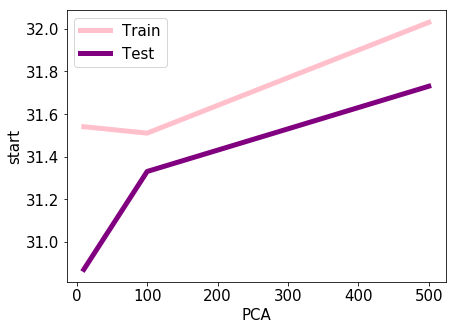

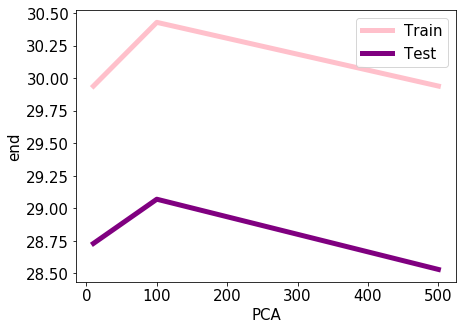

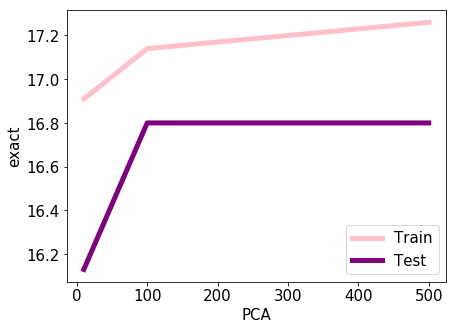

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.8, 5))
PCA = [10, 100, 500]
start_train = [31.54, 31.51, 32.03]
start_valid = [30.87, 31.33, 31.73]

end_train = [29.94, 30.43, 29.94]
end_valid = [28.73, 29.07, 28.53]


exact_train = [16.91, 17.14, 17.26]
exact_valid = [16.13, 16.80, 16.80]

plt.plot(PCA, start_train, lw=5, color='pink')
plt.plot(PCA, start_valid, lw=5, color='purple')
plt.legend(['Train', 'Test'], fontsize=15)
plt.xlabel('PCA', fontsize=15)
plt.ylabel('start', fontsize=15)
#plt.xlim([1, 50])
#plt.xticks(list(range(0, 1000, 100)) + [1000])
plt.tick_params(labelsize=15)
plt.savefig('start_PCA.png')
plt.show()

plt.figure(figsize=(6.8, 5))
plt.plot(PCA, end_train, lw=5, color='pink')
plt.plot(PCA, end_valid, lw=5, color='purple')
plt.legend(['Train', 'Test'], fontsize=15, loc='best')
plt.xlabel('PCA', fontsize=15)
plt.ylabel('end', fontsize=15)
#plt.xlim([1, 50])
#plt.xticks(list(range(0, 1000, 100)) + [1000])
plt.tick_params(labelsize=15)
plt.savefig('end_PCA.png')
plt.show()

plt.figure(figsize=(6.8, 5))
plt.plot(PCA, exact_train, lw=5, color='pink')
plt.plot(PCA, exact_valid, lw=5, color='purple')
plt.legend(['Train', 'Test'], fontsize=15)
plt.xlabel('PCA', fontsize=15)
plt.ylabel('exact', fontsize=15)
#plt.xlim([1, 50])
#plt.xticks(list(range(0, 1000, 100)) + [1000])
plt.tick_params(labelsize=15)
plt.savefig('exact_PCA.png')
plt.show()

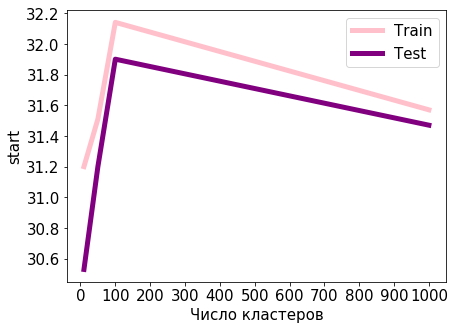

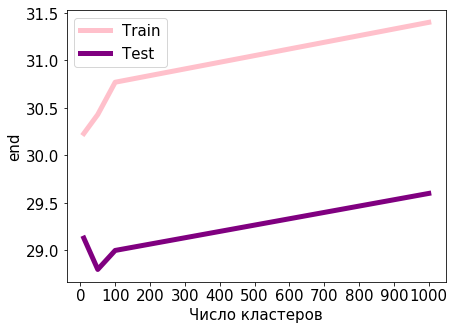

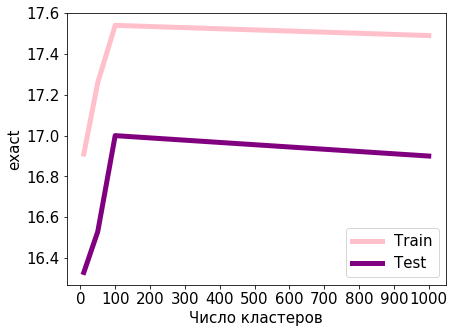

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.8, 5))
n_clusters = [1000,100, 50, 10]
start_train = [31.57, 32.14, 31.51, 31.20]
start_valid = [31.47, 31.90, 31.20, 30.53]

end_train = [31.40, 30.77, 30.43, 30.23]
end_valid = [29.60, 29.00, 28.80, 29.13]


exact_train = [17.49, 17.54, 17.26, 16.91]
exact_valid = [16.90, 17.00, 16.53, 16.33]

plt.plot(n_clusters, start_train, lw=5, color='pink')
plt.plot(n_clusters, start_valid, lw=5, color='purple')
plt.legend(['Train', 'Test'], fontsize=15)
plt.xlabel('Число кластеров', fontsize=15)
plt.ylabel('start', fontsize=15)
#plt.xlim([1, 50])
plt.xticks(list(range(0, 1000, 100)) + [1000])
plt.tick_params(labelsize=15)
plt.savefig('n_clusters_start.png')
plt.show()

plt.figure(figsize=(6.8, 5))
plt.plot(n_clusters, end_train, lw=5, color='pink')
plt.plot(n_clusters, end_valid, lw=5, color='purple')
plt.legend(['Train', 'Test'], fontsize=15, loc='best')
plt.xlabel('Число кластеров', fontsize=15)
plt.ylabel('end', fontsize=15)
#plt.xlim([1, 50])
plt.xticks(list(range(0, 1000, 100)) + [1000])
plt.tick_params(labelsize=15)
plt.savefig('n_clusters_end.png')
plt.show()

plt.figure(figsize=(6.8, 5))
plt.plot(n_clusters, exact_train, lw=5, color='pink')
plt.plot(n_clusters, exact_valid, lw=5, color='purple')
plt.legend(['Train', 'Test'], fontsize=15)
plt.xlabel('Число кластеров', fontsize=15)
plt.ylabel('exact', fontsize=15)
#plt.xlim([1, 50])
plt.xticks(list(range(0, 1000, 100)) + [1000])
plt.tick_params(labelsize=15)
plt.savefig('n_clusters_exact.png')
plt.show()

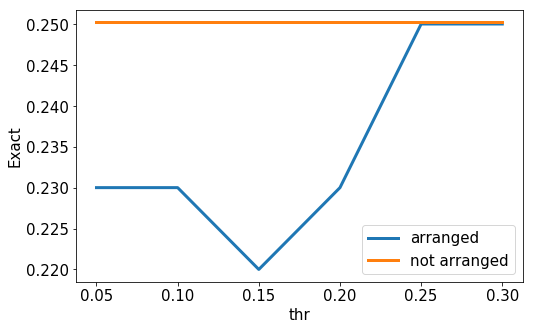

In [103]:
import matplotlib.pyplot as plt 
import numpy as np

plt.figure(figsize=(8, 5))
dir_ = 'data-science-journey-2017/problem_B/drqa-baseline'
#res1 = [0.19, 0.21, 0.2118, 0.2205, 0.2205]
res1 = []
res2 = []
time1 = []
time2 = []
thrs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
for thr in thrs:
    res1.append(np.load('{}/thr_{}_sorted_exact.npy'.format(dir_, thr)).item())
    res2.append(np.load('{}/thr_{}_exact.npy'.format(dir_, thr)).item())
    
    time1.append(np.load('{}/thr_{}_sorted_time.npy'.format(dir_, thr)).item())
    time2.append(np.load('{}/thr_{}_time.npy'.format(dir_, thr)).item())
    
res1[-1] = 0.25
plt.plot(thrs, res1, lw=3)
plt.plot(thrs, [0.2502] * len(thrs), lw=3)
plt.xlabel('thr', fontsize=15)
plt.ylabel('Exact', fontsize=15)
plt.legend(['arranged', 'not arranged'], loc = 'best', fontsize = 15)
plt.tick_params(labelsize=15)
plt.savefig('thrs.png')
plt.show()

In [164]:
#df = df.loc[df.index.unique()[:5000]]

In [3]:
from pymystem3 import Mystem

stem = Mystem()

def lemmatize(text):
    text_lem = ' '.join([''.join(stem.lemmatize(w.lower())).replace('\n', '') for w in text.split()])
    return text_lem
    
tqdm_pandas(tqdm(total=df.index.nunique()))
df['question_lem'] = df.groupby('question_id').progress_apply(lambda x: lemmatize(x.question.values[0]))

  0%|          | 0/50364 [00:00<?, ?it/s]
50365it [01:20, 622.24it/s]                           


In [4]:
import operator

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob as tb

def as_list_of_tokens(data):
    data_tokens = []
    ids = []

    for id_, text in data.items():
        data_tokens.append(list(tb(text).words)[:4])
        ids.append(id_)
    return data_tokens, ids

import numpy as np 
from scipy.sparse import csr_matrix


def as_sparse_matrix(documents):
    indptr = [0]
    indices = []
    data = []
    tokens = {}
    token_n = 0
    for document_tokens in documents:
        for token in document_tokens:
            if token not in tokens:
                tokens[token] = token_n
                token_n += 1

            indices.append(tokens[token])
            data.append(1)

        indptr.append(len(indices))
    sparse_matrix = csr_matrix((np.array(data), np.array(indices), np.array(indptr)),
                               shape=(len(documents), len(tokens)))
    return sparse_matrix, tokens, token_n


def tf_idf_transform(data_csr, tokens, ids):
    vectorizer = TfidfTransformer()
    vectors = vectorizer.fit_transform(data_csr)
    vectors = vectors.toarray() #dummy solution
    
    columns = [token[0] for token in sorted(tokens.items(), key=operator.itemgetter(1))]
    data = pd.DataFrame(vectors, columns=columns, index=ids)
    features = np.array(data.columns)
    return data, features, vectorizer

data_tokens, ids = as_list_of_tokens(df.question_lem.to_dict())
print('as_list_of_tokens finished...')
data_csr, tokens, token_n = as_sparse_matrix(data_tokens)
print('as_sparse_matrix finished...')
data, features, tf_idf_vectorizer = tf_idf_transform(data_csr, tokens, ids)
print('tf_idf_transform finished...')

as_list_of_tokens finished...
as_sparse_matrix finished...
tf_idf_transform finished...


In [5]:
df = df.reset_index()

interrogative_pronouns = ['кто', 'что', 'какой', 'чей', 'который', 'сколько', 'когда', 'где', 'куда', 'как', 'откуда', 'почемy', 'зачем']

for interrogative_pronoun in interrogative_pronouns:
    df['interrogative_pronoun_{}'.format(interrogative_pronoun)] = 0
    
for index, d in tqdm(df.iterrows(), total=df.shape[0]):
    for w in tb(d.question_lem).words:
        if w in interrogative_pronouns:
            df.loc[index, 'interrogative_pronoun_{}'.format(w)] = 1

100%|██████████| 50364/50364 [03:07<00:00, 268.23it/s]


In [6]:
data = data.reset_index()
data = data.rename(columns={'index': 'question_id'})

cols = df.columns.difference(['question_lem', 'question_id', 'answer', 'question'])
print(cols)
data = pd.merge(data, df[list(cols) + ['question_id']]
                , how='left', on='question_id')
data = data.set_index('question_id')

Index(['interrogative_pronoun_где', 'interrogative_pronoun_зачем',
       'interrogative_pronoun_как', 'interrogative_pronoun_какой',
       'interrogative_pronoun_когда', 'interrogative_pronoun_который',
       'interrogative_pronoun_кто', 'interrogative_pronoun_куда',
       'interrogative_pronoun_откуда', 'interrogative_pronoun_почемy',
       'interrogative_pronoun_сколько', 'interrogative_pronoun_чей',
       'interrogative_pronoun_что'],
      dtype='object')


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data[data.columns.difference(cols + ['question_id'])])

In [8]:
data_pca_full = np.hstack((data_pca, data[cols].values))
data_pca_full = pd.DataFrame(data_pca_full, index=data.index)

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, random_state=0).fit(data_pca_full)
data_pca_full['question_type'] = kmeans.labels_

In [10]:
df = pd.merge(df, data_pca_full.reset_index()[['question_id', 'question_type']], how='left', on='question_id')

In [11]:
df = df.set_index('question_id')

In [12]:
data_pca_full.to_pickle('data_pca_full.pkl')
df.to_pickle('df.pkl')

In [26]:
indices = []
for question_type in tqdm(data_pca_full.question_type.unique(), total=data_pca_full.question_type.nunique()):
    tmp = data_pca_full[data_pca_full.question_type == question_type]
    if tmp.shape[0] < 100:
        continue
    else:
        indices.extend(np.random.choice(tmp.index, size=100, replace=False))

100%|██████████| 100/100 [00:00<00:00, 553.82it/s]


In [31]:
q_types = list(data_pca_full.question_type.value_counts()[:10].index)

In [32]:
part = data_pca_full[data_pca_full.question_type.isin(q_types)].sample(n=100)

In [34]:
part.question_type.nunique()

10

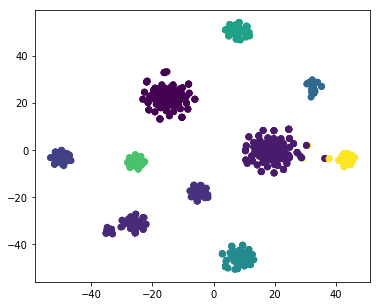

In [36]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 
plt.figure(figsize=(6, 5))
tsne = TSNE(n_components=2, init='pca', random_state=241)
part = data_pca_full[data_pca_full.question_type.isin(q_types)].sample(n=1000)
data_tsne = tsne.fit_transform(part[part.columns.difference(['question_type'])])
#plt.figure(figsize=(7, 6))
#plt.title('MNIST(t-SNE)')
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=part['question_type'])
plt.show()

In [76]:
part.question_type.unique()

array([43,  1, 25, 15, 21, 31,  4,  6,  7,  9])

In [92]:
df.loc[part[part.question_type == 15].index].question.unique()

array(['В каком году Куско был покорен испанцами?',
       'В каком году Еврипид оставил Афины?',
       'В каком году вышла вторая комедия Оскара Уайльда?',
       'В каком году 186 ведущих мировых учёных выступили с заявлением Возражения против астрологии ?',
       'В каком году Толкин вернулся в Оксфорд?',
       'В каких годах появился этимологический словарь русского языка?',
       'В каком году оператор телерадиовещания должен обеспечить параллельную эксплуатацию аналоговой сети?',
       'В каком году Линней сдал экзамены?',
       'В каком году Ривер Плейт впервые в своей истории вышел из Примеры?',
       'В каком году Рязанов стал режиссёром киностудии?',
       'В каком году WhoTrades получил премию выставки China Forex Expo?',
       'В каком году Всеволод Чермный завоевал Киев?',
       'В каком году написано произведение Байрона Первая песня Морганте Маджиора ',
       'В каком году Гомельщина была присоединена князем Ольгердом к ВКЛ?',
       'В каком году создан Стату

In [ ]:
43: 
    
    Правительство какого штата в Индии выпустило документ о переходе всех местных школ на использование Linux?
    В каком возрасте поступают в высшие школы Республики Корея?
    В соответсвии какого ГОСТа в России троллейбус должен эксплуатироваться на дорогах категорий Т или П с покрытием капитального типа?
    В каком звании король Луи-Филипп назначил Лафайета Жильбера?
    В каком формате ACTE проводит образовательные мероприятия по всему миру?
    
1: 
    Что дало использование водолазного скафандра?
    Что стало последним сочинением Шостаковича?
    Чем пользуется физиология высшей нервной деятельности при изучении высших психических функций?
    Чем обладает любая полифоническая пьеса?
    Что сделал Руссо?
    
4: 
    Какие частоты слышат мыши ?
    Какими домами славится Труа?
    Какие вещества способны обратимо изменять светопоглощение?
    Какой важнейший фактор, предпределяющий распространение бабочек?
    Какая река разделила Афины?
    
21:
    Кто стал луреатом Нобелевской премии в 1906 году вместо Менделеева?
    Кто сделал весы необходимой принадлежностью химической лаборатории?
    Кого принял Апостол Иоанн?
    Кто предложил использовать подстановки (англ. substitution) и перестановки (англ. permutation)?
    Кто режиссер фильма Голубая бабочка ?

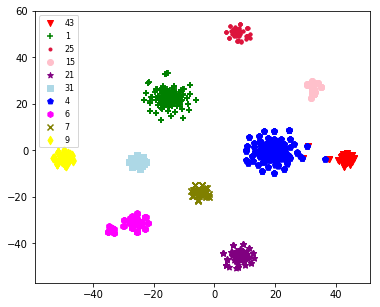

In [87]:
plt.figure(figsize=(6, 5))
markers = ["v", '+', '.', 'o', '*', "s", "p", 'h', 'x', 'd']
colors = ['red','green','crimson','pink', 'purple', 'lightblue', 'blue', 'magenta', 'olive','yellow']
handles = []
for i, c in enumerate(part.question_type.unique()):
    index = part.reset_index()[part.reset_index().question_type == c].index
    plt.scatter(data_tsne[index, 0], data_tsne[index, 1], c=colors[i], marker=markers[i])
    handles.append(plt.scatter(data_tsne[index, 0], data_tsne[index, 1], c=colors[i], marker=markers[i]))
    
plt.legend(handles, part.question_type.unique(), loc=2, fontsize=8)
plt.savefig('q_types.png')
plt.show()

In [12]:
from textblob import TextBlob as tb
from natasha import DatesExtractor
import pymorphy2

dates_extractor = DatesExtractor()
morph = pymorphy2.MorphAnalyzer()

# Неры ответов
def get_answer_ners(x):
    ners = set()

    dates_matches = dates_extractor(x.answer)
    dates = [token.value for date in dates_matches for token in date.tokens]
    if len(dates):
        ners.add('Date')

    for w in tb(x.answer).words:
        tag = morph.parse(w)[0].tag
        if ('Name' in tag) or ('Surn' in tag) or ('Patr' in tag):
            ners.add('Per')
        elif 'Geox' in tag:
            ners.add('Geox')
        elif 'Orgn' in tag:
            ners.add('Orgn')
        elif ('ROMN' in tag) or (w.split('-')[0].isdigit()) and (len(w.split('-')) > 1):
            ners.add('Date')
        elif (w not in dates) and (('NUMR' in tag) or ('NUMB' in tag)):
            ners.add('Num')
    return ners
 
print('Неры ответов start...{}'.format(df.shape))
tqdm_pandas(tqdm(total=df.shape[0]))
df['answer_ners'] = df.progress_apply(lambda x: get_answer_ners(x), axis=1)

# Индикаторы неров в ответах
def get_answer_ners_indicators(x):
    for ner in x.answer_ners:
         x[ner] = 1
    return x
ners = ['Per', 'Geox', 'Orgn', 'Date', 'Num']
print('Индикаторы неров в ответах start...{}'.format(df.shape))
for ner in ners:
    df[ner] = 0    
tqdm_pandas(tqdm(total=df.shape[0]))
df = df.progress_apply(lambda x: get_answer_ners_indicators(x), axis=1)

    
# local: сколько раз нер встретился в ответ на данный типа вопрос
def get_ners_counts_by_question_type(x, ners):
    for ner in ners:
        x['{}_local'.format(ner)] = x[ner].sum()
    return x    
print('local counts start...{}'.format(df.shape))
tqdm_pandas(tqdm(total=df.question_type.nunique()))
df = df.groupby('question_type').progress_apply(lambda x: get_ners_counts_by_question_type(x, ners))
   
    
# Определяем самый типовой нер для данного типа вопроса
def get_most_freq_ner_question_type(x, ners):
    tmp = x[['{}_local'.format(ner) for ner in ners]].values[0]
    if np.max(tmp) < 0.2 * x.shape[0]:
        x['question_type_ner'] = ''
    else:
        x['question_type_ner'] = ners[np.argmax(tmp)]
    return x
print('Типовой нер start...{}'.format(df.shape))
tqdm_pandas(tqdm(total=df.question_type.nunique()))
df = df.groupby('question_type').progress_apply(lambda x: get_most_freq_ner_question_type(x, ners))

  0%|          | 22/50364 [00:00<03:51, 217.25it/s]

Неры ответов start...(50364, 17)


  0%|          | 2/50364 [00:00<57:22, 14.63it/s]

Индикаторы неров в ответах start...(50364, 18)


50365it [00:05, 9012.53it/s]                            
 39%|███▉      | 39/100 [00:00<00:00, 384.80it/s]

local counts start...(50364, 23)


101it [00:00, 280.68it/s]                        
 89%|████████▉ | 89/100 [00:00<00:00, 885.76it/s]

Типовой нер start...(50364, 28)


101it [00:00, 437.29it/s]                        


In [13]:
df.question_type_ner.value_counts()

        31844
Date     5739
Per      5309
Num      4563
Geox     2909
Name: question_type_ner, dtype: int64

In [15]:
df[['question', 'question_type', 'question_type_ner']].drop_duplicates()

,question,question_type,question_type_ner
question_id,,,
60544,Где встречаются первые упоминания о строении ч...,30,Geox
1604,Как называется корректирующая оптическая систе...,24,
30350,Какая теория была отвергнута после смерти Веге...,63,Per
53270,Чему не уступают по красоте изделия из прессов...,67,
75698,На какие группы классифицируют дифтонги?,22,Num
71431,На что в дальнейшем смогут рассчитывать зарубе...,61,
58761,Что имеет каждый судебный округ?,1,
18725,"Что используются и в военных целях, например, ...",64,Geox
28808,"Что в гораздо большей степени зависит от того,...",42,


In [14]:
df_old = pd.read_csv('train_task_b.csv')
df_old = df_old.set_index('question_id')
#df_old = df_old.loc[df_old.index.unique()[:5000]]

In [15]:
df_old = pd.merge(df_old.reset_index(), df.reset_index()[['question_id', 'question_type_ner']], how='left', on='question_id')

In [16]:
df_old = df_old.set_index('question_id')

In [17]:
train_idxs, test_idxs = Utility.train_test_split(df_old)

In [19]:
# 3500: Train, 1500: Test 
df_old.loc[train_idxs].shape

(35255, 5)

In [20]:
df_old.loc[train_idxs].to_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/train.csv')

In [21]:
df_old.loc[test_idxs].to_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/test.csv')

In [48]:
df_old.loc[df_old.index.unique()[:100]].to_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/small_train.csv')

In [77]:
pd.read_csv('data-science-journey-2017/problem_B/drqa-baseline/scripts/reader/test.csv').question_id.isin(

,question_id,paragraph_id,paragraph,question,answer,question_type_ner
0,35442,6052,Система различительных признаков может строить...,Что характерно при использовании привативной о...,наличие артикуляционной характеристики являетс...,NaN
1,77540,7812,Возникновение системного интереса к народному ...,Кто в XIX веке собирал руны Калевалы в Карелии?,Элиас Лённрот,Per
2,25193,7769,Со второй половины XIX века во многих странах ...,"Что нужно рассчитывать, учитывая вес осужденного?",длину верёвки,NaN
3,50786,12518,"Многие виды имеют покровительственную окраску,...",Бабочки из какого рода имеют ярко окрашенную в...,из рода Kallima,NaN
4,23837,4889,"Половая зрелость наступает в 3—6 лет, но замед...",Сколько лет живут мелкие предствители китообра...,до 30 лет,Num
5,49001,6968,В южных тропиках господствует юго-восточный па...,Где чаще всего возникают ураганы?,"в западной части океана (до 8 раз в год), в ра...",Geox
6,67875,10030,Движение троллейбусов регламентируется графико...,От чего зависит распределение наличного парка ...,От пассажиропотоков,NaN
7,65959,6866,В 1890 году среди индейцев началось мессианско...,Чем была вера в чудесное возрождение индейског...,Характерной чертой,NaN
8,76436,7574,"Пористое вулканическое стекло, образовавшееся ...",Что образуется в результате выделения газов пр...,пористое вулканическое стекло,NaN
9,28770,13261,Оборотные пути могут не строиться в случае низ...,В самарском метрополитене станции о съездами?,"На станциях Юнгородок, Российская и Алабинская",Num


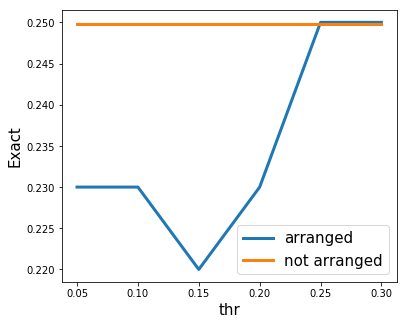

In [8]:
import matplotlib.pyplot as plt 
import numpy as np

plt.figure(figsize=(6, 5))
dir_ = 'data-science-journey-2017/problem_B/drqa-baseline'
#res1 = [0.19, 0.21, 0.2118, 0.2205, 0.2205]
res1 = []
res2 = []
time1 = []
time2 = []
thrs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
for thr in thrs:
    res1.append(np.load('{}/thr_{}_sorted_exact.npy'.format(dir_, thr)).item())
    res2.append(np.load('{}/thr_{}_exact.npy'.format(dir_, thr)).item())
    
    time1.append(np.load('{}/thr_{}_sorted_time.npy'.format(dir_, thr)).item())
    time2.append(np.load('{}/thr_{}_time.npy'.format(dir_, thr)).item())
    
res1[-1] = 0.25
plt.plot(thrs, res1, lw=3)
plt.plot(thrs, [0.2498] * len(thrs), lw=3)
plt.xlabel('thr', fontsize=15)
plt.ylabel('Exact', fontsize=15)
plt.legend(['arranged', 'not arranged'], loc = 'best', fontsize = 15)
plt.savefig('thrs.png')
plt.show()

In [27]:
res1

[0.23, 0.23, 0.22, 0.23, 0.25, 0.24, 0.22]

In [24]:
20180422-c5237f95.mdl

17.77777777777778

In [5]:
from textblob import TextBlob as tb
len(tb('Б.').words)

1

In [ ]:
start: 0.44, end: 0.36, exact: 0.23
total time : 0.020945820808410644
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.95it/s]
start: 0.43, end: 0.35, exact: 0.23
total time : 0.0196258282661438
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.60it/s]
start: 0.41, end: 0.35, exact: 0.22
total time : 0.022800779342651366
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.79it/s]
start: 0.41, end: 0.35, exact: 0.23
total time : 0.030229594707489014
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.81it/s]
start: 0.43, end: 0.34, exact: 0.25
total time : 0.03750667572021484
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.23it/s]
start: 0.42, end: 0.31, exact: 0.24
total time : 0.050764071941375735
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.87it/s]
start: 0.39, end: 0.3, exact: 0.22
total time : 0.06602370262145996
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.54it/s]
start: 0.37, end: 0.26, exact: 0.2
total time : 0.08539803504943848
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.26it/s]
start: 0.34, end: 0.25, exact: 0.19
total time : 0.11973047971725465
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]
start: 0.31, end: 0.24, exact: 0.18
total time : 0.16371222734451293

In [ ]:
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.98it/s]
start: 0.18, end: 0.13, exact: 0.07
total time : 0.020798356533050538
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.77it/s]
start: 0.22, end: 0.16, exact: 0.11
total time : 0.020866665840148926
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.49it/s]
start: 0.21, end: 0.19, exact: 0.11
total time : 0.023742191791534424
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.17it/s]
start: 0.29, end: 0.24, exact: 0.16
total time : 0.030130724906921386
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.26it/s]
start: 0.3, end: 0.24, exact: 0.17
total time : 0.03854474306106567
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.22it/s]
start: 0.32, end: 0.24, exact: 0.18
total time : 0.051026151180267335
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.20it/s]
start: 0.33, end: 0.25, exact: 0.18
total time : 0.06477129220962524
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.20it/s]
start: 0.35, end: 0.25, exact: 0.2
total time : 0.08825971603393555
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.33it/s]
start: 0.31, end: 0.24, exact: 0.18
total time : 0.11902605772018432
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.06it/s]
start: 0.29, end: 0.23, exact: 0.17
total time : 0.16393214225769043